## 1 Download

In [176]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784")

# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Image Data Shape" , mnist.data.shape)
# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", mnist.target.shape)

Image Data Shape (70000, 784)
Label Data Shape (70000,)


## 2 Split dataset to test and training datasets

In [177]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_lbl, test_lbl = train_test_split(mnist.data, mnist.target, test_size=1/7.0, random_state=0)
train_lbl = np.asarray(train_lbl,'float64')
test_lbl = np.asarray(test_lbl,'float64')
train_img.shape
test_img.shape

(10000, 784)

### Display data

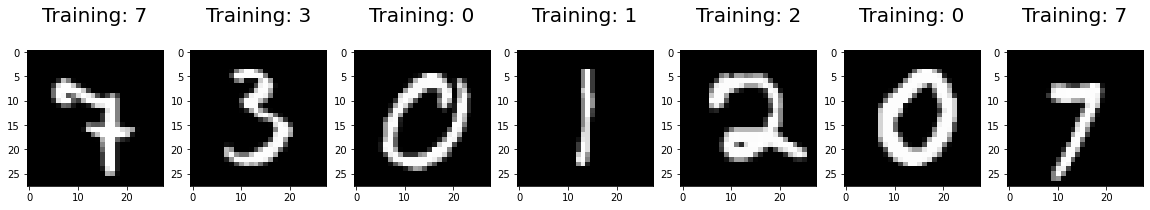

In [178]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(train_img[0:7], train_lbl[0:7])):
    plt.subplot(1, 7, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

1.0    6736
7.0    6229
3.0    6128
9.0    5989
2.0    5950
0.0    5907
6.0    5887
4.0    5862
8.0    5862
5.0    5450
dtype: int64


<AxesSubplot:>

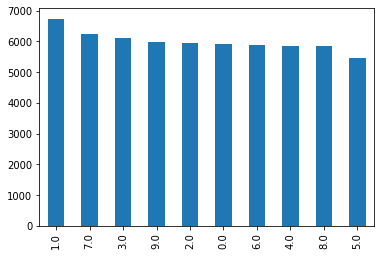

In [179]:
import pandas as pd
index = pd.Index(train_lbl)
print(index.value_counts())
index.value_counts().plot(kind='bar')

## 3 PCA dimension reduction

In [207]:
from sklearn.decomposition import PCA
from time import time
n_components = 40
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_img)
print("done in %0.3fs" % (time() - t0))
train_img_pca = pca.transform(train_img)
print(train_img_pca.shape)
print(pca.components_.shape)

done in 2.939s
(60000, 40)
(40, 784)


<ipython-input-208-065e1cc31a9e>:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1)


0.7869964211975251


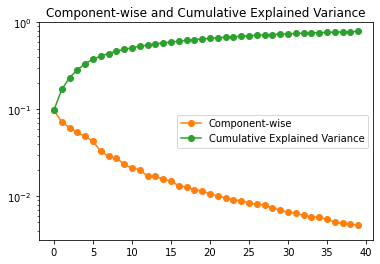

In [208]:
plt.hist(pca.explained_variance_ratio_, bins=n_components, log=True)
sum_var = pca.explained_variance_ratio_.sum()

plt.plot(range(40), pca.explained_variance_ratio_, 'o-', label='Component-wise')
plt.plot(range(40), np.cumsum(pca.explained_variance_ratio_), 'o-', label='Cumulative Explained Variance')
plt.title("Component-wise and Cumulative Explained Variance")
plt.legend()
plt.ylim(0, 1)

print(sum_var)

In [219]:
pca.explained_variance_ratio_

array([0.09750254, 0.07153075, 0.06158614, 0.05417764, 0.04872839,
       0.04294688, 0.03287332, 0.02887584, 0.02754721, 0.02341615,
       0.02108954, 0.02031241, 0.0170308 , 0.01692814, 0.01582776,
       0.01487742, 0.01321472, 0.01275759, 0.01187607, 0.0115657 ,
       0.01067944, 0.01004658, 0.0095696 , 0.00908137, 0.00888438,
       0.00838161, 0.00810786, 0.00789388, 0.00738845, 0.00693705,
       0.00654919, 0.00643055, 0.00601524, 0.00585018, 0.00570691,
       0.00543173, 0.00504417, 0.00487881, 0.00479492, 0.00465949])

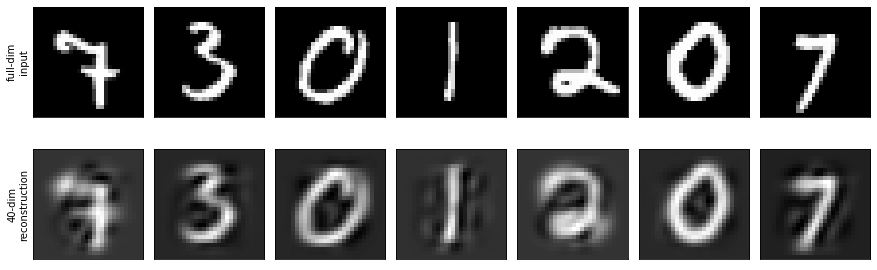

In [193]:
projected_pca = pca.inverse_transform(train_img_pca)
fig, ax = plt.subplots(2, 7, figsize=(15, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(7):
    ax[0, i].imshow(train_img[i].reshape(28, 28), cmap=plt.cm.gray)
    ax[1, i].imshow(projected_pca[i].reshape(28, 28), cmap=plt.cm.gray)
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('40-dim\nreconstruction');

Text(0.5, 1.0, 'Projection on the 2 first principal axis')

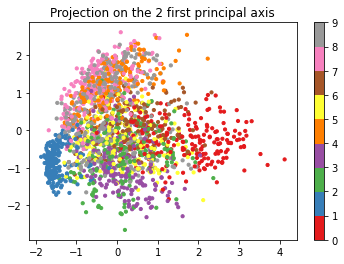

In [209]:
plt.scatter(train_img_pca[0:2000, 0], train_img_pca[0:2000, 1], c=train_lbl[0:2000], s=10, cmap='Set1')
#plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn))
plt.colorbar()
plt.title('Projection on the 2 first principal axis')

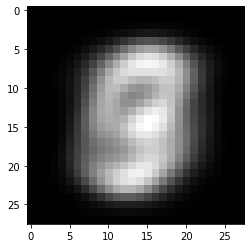

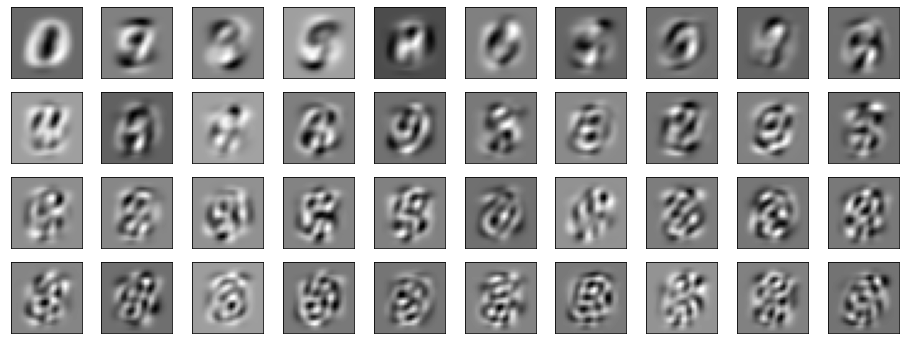

In [210]:
plt.imshow(pca.mean_.reshape(np.reshape(train_img[0], (28,28)).shape), cmap=plt.cm.gray)
fig = plt.figure(figsize=(16, 6))
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(np.reshape(train_img[0], (28,28)).shape), cmap=plt.cm.gray)
#cmap='bwr'

## 3.1 SVM + Cross validation

In [83]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid = [
#  {'C': [10, 100], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [0.1, 0.05, 0.01, 0.005, 0.001], 'kernel': ['rbf']}
  ]

t0 = time()
svm_clsf = svm.SVC()
grid_clsf = GridSearchCV(svm_clsf,param_grid,n_jobs=1, verbose=2,cv=10)
grid_clsf.fit(train_img_pca, train_lbl)
print("done in %0.3fs" % (time() - t0))
classifier = grid_clsf.best_estimator_
params = grid_clsf.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 5.0min
[CV] C=1, gamma=0.1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.0min remaining:    0.0s


[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 5.0min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 5.0min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 4.9min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 4.9min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 5.0min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 5.0min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total= 5.0min
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=10, gamma=0.1, kernel=rbf, total= 5.0min
[CV] C=10, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=10, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=10, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=10, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=10, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=10, gamma=0.05, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=10, gamma=0.05, kernel=rbf ....................................
[CV] .

[CV] .................... C=100, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=100, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=100, gamma=0.05, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.05, kernel=rbf, total= 1.3min
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.01, kernel=rbf, total=  22.6s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.01, kernel=rbf, total=  23.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.01, kernel=rbf, total=  22.7s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .................... C=100, gamma=0.01, kernel=rbf, total=  23.0s
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=  22.8s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=  23.1s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=  23.0s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=  22.9s
[CV] C=1000, gamma=0.01, kernel=rbf ..................................
[CV] ................... C=1000, gamma=0.01, kernel=rbf, total=  23.2s
[CV] C=1000, gamma=0.005, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.005, kernel=rbf, total=  22.6s
[CV] C=1000, gamma=0.005, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.005, kernel=rbf, total=  22.5s
[CV] C=1000, gamma=0.005, kernel=rbf .................................
[CV] .

[CV] ................. C=10000, gamma=0.005, kernel=rbf, total=  22.7s
[CV] C=10000, gamma=0.005, kernel=rbf ................................
[CV] ................. C=10000, gamma=0.005, kernel=rbf, total=  22.9s
[CV] C=10000, gamma=0.005, kernel=rbf ................................
[CV] ................. C=10000, gamma=0.005, kernel=rbf, total=  22.8s
[CV] C=10000, gamma=0.005, kernel=rbf ................................
[CV] ................. C=10000, gamma=0.005, kernel=rbf, total=  22.8s
[CV] C=10000, gamma=0.005, kernel=rbf ................................
[CV] ................. C=10000, gamma=0.005, kernel=rbf, total=  22.6s
[CV] C=10000, gamma=0.005, kernel=rbf ................................
[CV] ................. C=10000, gamma=0.005, kernel=rbf, total=  22.6s
[CV] C=10000, gamma=0.005, kernel=rbf ................................
[CV] ................. C=10000, gamma=0.005, kernel=rbf, total=  22.6s
[CV] C=10000, gamma=0.001, kernel=rbf ................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 397.1min finished


done in 23915.775s


In [221]:
params

{'C': 100, 'gamma': 0.05, 'kernel': 'rbf'}

In [84]:
predictions = classifier.predict(pca.transform(test_img))
# evalution
score = classifier.score(pca.transform(test_img), test_lbl)
print(score)

0.9845


In [85]:
pd.pivot_table(pd.DataFrame(grid_clsf.cv_results_), values='mean_test_score', index='param_C', columns='param_gamma')

param_gamma,0.001,0.005,0.010,0.050,0.100
param_C,,,,,
1,0.925550,0.959717,0.973133,0.984033,0.975133
10,0.946383,0.978100,0.982200,0.984867,0.976050
100,0.971217,0.980700,0.981067,0.984900,0.976050
1000,0.979483,0.978733,0.980667,0.984900,0.976050
10000,0.976550,0.978683,0.980667,0.984900,0.976050


<AxesSubplot:xlabel='param_gamma', ylabel='param_C'>

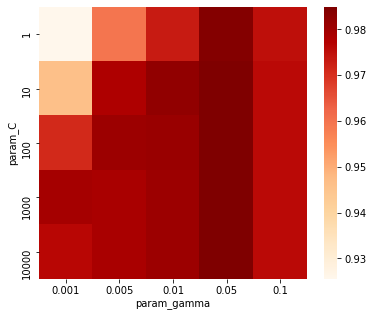

In [110]:
import seaborn as sns 
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(grid_clsf.cv_results_), values='mean_test_score', index='param_C', columns='param_gamma')
plt.figure(figsize=(6,5))      
sns.heatmap(pvt, cmap = 'OrRd')

[[ 992    0    1    0    0    0    2    0    1    0]
 [   0 1132    3    1    0    0    0    2    2    1]
 [   1    0 1028    1    1    0    0    3    5    1]
 [   0    0    8  990    0    6    0    2    7    0]
 [   1    0    1    0  955    1    0    1    0    3]
 [   0    0    2    4    1  845    6    0    3    2]
 [   2    0    0    0    3    6  975    0    3    0]
 [   1    2    8    1    2    1    0 1043    0    6]
 [   0    4    5    3    0    0    2    1  941    7]
 [   1    0    1    6    6    3    1    3    4  944]]


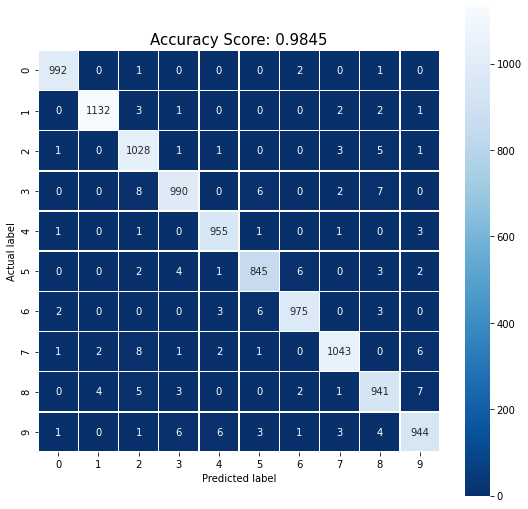

In [96]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(test_lbl, predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="1d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [122]:
from sklearn import metrics
print(metrics.classification_report(test_lbl, predictions))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       996
         1.0       0.99      0.99      0.99      1141
         2.0       0.97      0.99      0.98      1040
         3.0       0.98      0.98      0.98      1013
         4.0       0.99      0.99      0.99       962
         5.0       0.98      0.98      0.98       863
         6.0       0.99      0.99      0.99       989
         7.0       0.99      0.98      0.98      1064
         8.0       0.97      0.98      0.98       963
         9.0       0.98      0.97      0.98       969

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## 3.2 Ridge regression

In [216]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
param_grid = [
  {'alpha':[1e-7, 4e-7, 8e-7, 1e-6, 4e-6, 8e-6, 1e-5, 4e-5, 8e-5, 1e-4, 4e-4, 8e-4, 1e-4, 1e-2, 1e-1, 1e2, 1e4, 1e6]}
  ]

t0 = time()
reg_clsf = RidgeClassifier()
reg_grid_clsf = GridSearchCV(reg_clsf,param_grid,n_jobs=1, verbose=2, cv=10)
reg_grid_clsf.fit(train_img_pca, train_lbl)
print("done in %0.3fs" % (time() - t0))
reg_classifier = reg_grid_clsf.best_estimator_
reg_params = reg_grid_clsf.best_params_

reg_predictions = reg_classifier.predict(pca.transform(test_img))
# evalution
reg_score = reg_classifier.score(pca.transform(test_img), test_lbl)
print(reg_score)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] alpha=1e-07 .....................................................
[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................
[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................
[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................
[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................
[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................
[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................
[CV] ...................................... alpha=1e-07, total=   0.1s
[CV] alpha=1e-07 .....................................................
[CV] .

[CV] ...................................... alpha=8e-06, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .

[CV] ..................................... alpha=0.0008, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] .

[CV] .................................. alpha=1000000.0, total=   0.1s
done in 12.099s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   12.0s finished


0.8276


In [220]:
reg_params

{'alpha': 1e-07}

In [212]:
pd.pivot_table(pd.DataFrame(reg_grid_clsf.cv_results_), 
               values='mean_test_score', index='param_alpha')

,mean_test_score
param_alpha,
1.000000e-07,0.834583
4.000000e-07,0.834583
8.000000e-07,0.834583
1.000000e-06,0.834583
4.000000e-06,0.834583
8.000000e-06,0.834583
1.000000e-05,0.834583
4.000000e-05,0.834583
8.000000e-05,0.834583


<AxesSubplot:ylabel='param_alpha'>

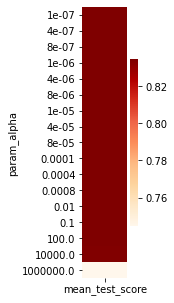

In [213]:
import seaborn as sns 
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(reg_grid_clsf.cv_results_), values='mean_test_score', index='param_alpha')
plt.figure(figsize=(1,5))      
sns.heatmap(pvt, cmap = 'OrRd')

[[ 932    1    3    9    5   10   25    5    5    1]
 [   0 1116    6    1    1    4    3    1    9    0]
 [  13   60  802   28   25    1   35   38   33    5]
 [   9   39   51  802    1   24    8   32   21   26]
 [   0   23    7    0  818    1   18    3    9   83]
 [  34   35    8   96   27  521   50   33   41   18]
 [  22   13    8    1   14   21  903    1    6    0]
 [  14   69   13    8   34    0    1  908    2   15]
 [  10   92    8   47   15   28    8   10  720   25]
 [  17   26    3   18   72   13    6   49   11  754]]


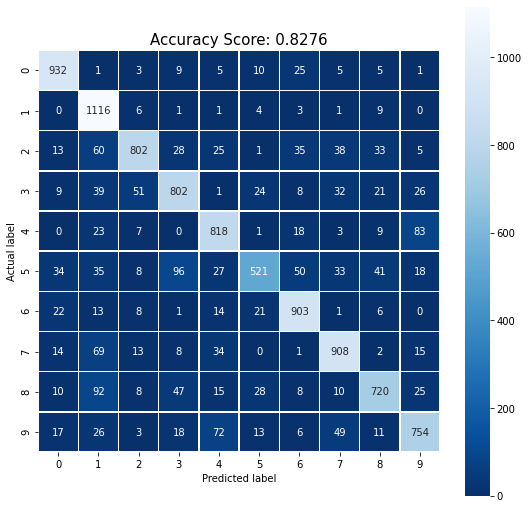

In [214]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(test_lbl, reg_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="1d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(reg_score)
plt.title(all_sample_title, size = 15);


In [215]:
from sklearn import metrics
print(metrics.classification_report(test_lbl, reg_predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91       996
         1.0       0.76      0.98      0.85      1141
         2.0       0.88      0.77      0.82      1040
         3.0       0.79      0.79      0.79      1013
         4.0       0.81      0.85      0.83       962
         5.0       0.84      0.60      0.70       863
         6.0       0.85      0.91      0.88       989
         7.0       0.84      0.85      0.85      1064
         8.0       0.84      0.75      0.79       963
         9.0       0.81      0.78      0.80       969

    accuracy                           0.83     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.83      0.82     10000



## 3.3 KNN

In [97]:
from sklearn import neighbors
param_grid = [
  {'n_neighbors':[1, 2, 3, 4, 5]}
  ]

t0 = time()
knn_clsf = neighbors.KNeighborsClassifier()
knn_grid_clsf = GridSearchCV(knn_clsf,param_grid,n_jobs=1, verbose=2, cv=10)
knn_grid_clsf.fit(train_img_pca, train_lbl)
print("done in %0.3fs" % (time() - t0))
knn_classifier = knn_grid_clsf.best_estimator_
knn_params = knn_grid_clsf.best_params_

knn_predictions = knn_classifier.predict(pca.transform(test_img))
# evalution
knn_score = knn_classifier.score(pca.transform(test_img), test_lbl)
print(knn_score)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... n_neighbors=1, total=  34.5s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.5s remaining:    0.0s


[CV] .................................... n_neighbors=1, total=  38.1s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=  32.4s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=  38.6s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=  38.7s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=  39.1s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=  38.6s
[CV] n_neighbors=1 ...................................................
[CV] .................................... n_neighbors=1, total=  38.6s
[CV] n_neighbors=1 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 33.1min finished


done in 1986.465s
0.9725


In [98]:
pd.pivot_table(pd.DataFrame(knn_grid_clsf.cv_results_), values='mean_test_score', index='param_n_neighbors')

,mean_test_score
param_n_neighbors,
1,0.968800
2,0.963583
3,0.970533
4,0.969300
5,0.969700


<AxesSubplot:ylabel='param_n_neighbors'>

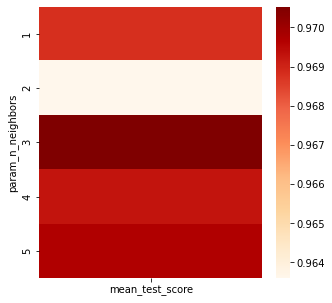

In [102]:
import seaborn as sns 
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(knn_grid_clsf.cv_results_), values='mean_test_score', index='param_n_neighbors')
plt.figure(figsize=(5, 5))      
sns.heatmap(pvt,cmap = 'OrRd')

[[ 991    0    0    0    0    1    2    0    1    1]
 [   0 1137    3    1    0    0    0    0    0    0]
 [   5    1 1010    5    0    1    0   12    5    1]
 [   0    2   15  968    1    9    0    4   10    4]
 [   0    6    0    0  941    0    2    2    0   11]
 [   1    0    2   16    1  826   11    2    1    3]
 [   5    0    1    0    1    5  976    0    1    0]
 [   1    7    4    0    2    0    0 1044    0    6]
 [   0   11    7   12    2    8    9    2  903    9]
 [   2    4    2   10   11    2    1    6    2  929]]


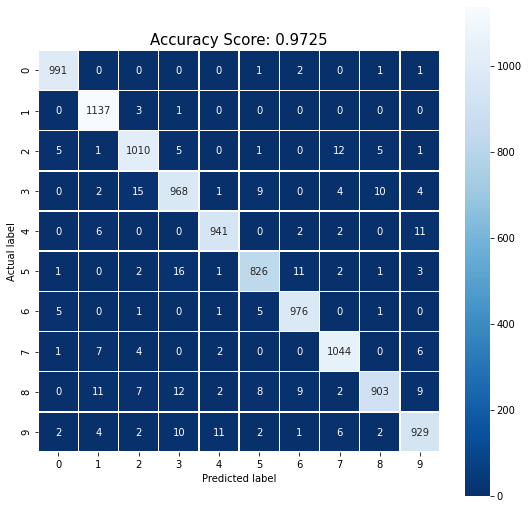

In [108]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
cm = metrics.confusion_matrix(test_lbl, knn_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="1d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(knn_score)
plt.title(all_sample_title, size = 15);

In [121]:
from sklearn import metrics
print(metrics.classification_report(test_lbl, knn_predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       996
         1.0       0.97      1.00      0.98      1141
         2.0       0.97      0.97      0.97      1040
         3.0       0.96      0.96      0.96      1013
         4.0       0.98      0.98      0.98       962
         5.0       0.97      0.96      0.96       863
         6.0       0.98      0.99      0.98       989
         7.0       0.97      0.98      0.98      1064
         8.0       0.98      0.94      0.96       963
         9.0       0.96      0.96      0.96       969

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [170]:
from sklearn.decomposition import PCA
from time import time
n_components = 40
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_img)
print("done in %0.3fs" % (time() - t0))
train_img_pca40 = pca.transform(train_img)
print(train_img_pca.shape)
print(pca.components_.shape)
projected40 = pca.inverse_transform(train_img_pca40)

done in 3.547s
(60000, 40)
(40, 784)


In [171]:
from sklearn.decomposition import PCA
from time import time
n_components = 100
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(train_img)
print("done in %0.3fs" % (time() - t0))
train_img_pca100 = pca.transform(train_img)
print(train_img_pca.shape)
print(pca.components_.shape)
projected100 = pca.inverse_transform(train_img_pca100)

done in 3.603s
(60000, 40)
(100, 784)


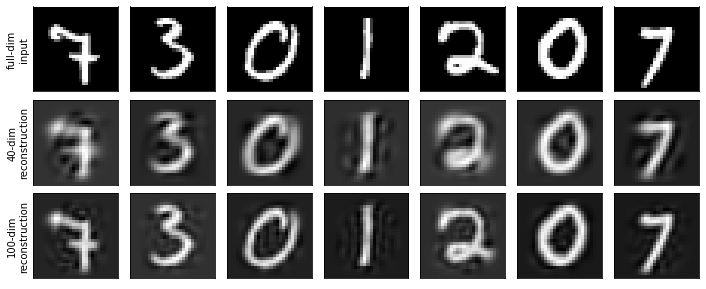

In [174]:
fig, ax = plt.subplots(3, 7, figsize=(12, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(7):
    ax[0, i].imshow(train_img[i].reshape(28, 28), cmap=plt.cm.gray)
    ax[1, i].imshow(projected40[i].reshape(28, 28), cmap=plt.cm.gray)
    ax[2, i].imshow(projected100[i].reshape(28, 28), cmap=plt.cm.gray)
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('40-dim\nreconstruction')
ax[2, 0].set_ylabel('100-dim\nreconstruction');


(70000, 784)